# Computer Vision Exercise 5 - Variational AutoEncoder
In this exercise, we are going to implement a type of generative model called **Variational AutoEncoder (VAE)** and its variant called **Conditional Variational AutoEncoder (CVAE)** that can generate the output conditioned on additional signals such as class labels.

We will use the MNIST dataset which is a collection of hand-written images of 10 digits.

**Your task**: Fill in the missing code according to the assignment descriptiond.

**Note**: You should run this notebook with GPU. Using Google Colab is encouraged for people without CUDA-enable machine. The training with GPU should take  take around 5 - 10 minutes.

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from tqdm import tqdm

In [2]:
# Prepare the MNIST dataset
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Download and load the test data
test_dataset = datasets.MNIST('./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.2MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# Check data size
print(train_dataset.data.shape)  # [N, height, width]
print(test_dataset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


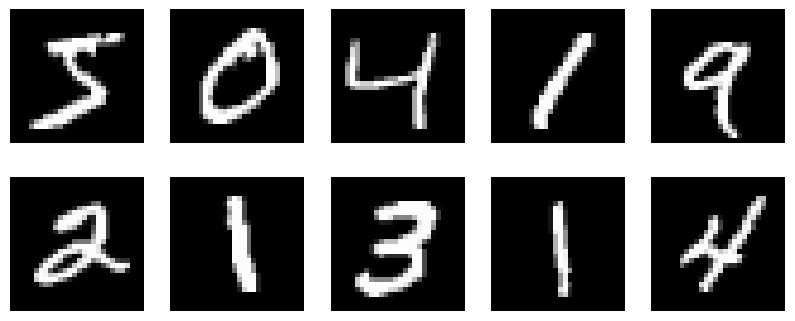

In [4]:
# Display 10 images from the MNIST dataset
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_dataset.data[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()

### VAE model (50 points)
In standard VAE implementation, the model consists of an **encoder** that encodes the training image into a latent vector and a **decoder** that transforms the latent vector into output an image. As the goal of VAE is to produce a distribution that we can sample from, the output of the encoder is not any latent vector but is a mean and a variance of a Gaussian distribution (which we will implement in log space for numerical stability).

Your model must meet the following specifications:

*   **Encoder** - consists of 1 input layer, 1(or more) hidden layer, and 2 branches of output layer that produce **the mean and log variance** in the latent space.
*   **Decoder** - consists of 1 input layer, 0(or more) and 1 output layer.
* All layers are normal feed-forward layers (sometimes called MLP).
* We will use ReLu activations for all layers except for the output of the decoder, which we will use the Sigmoid function to ensure that the output is in the [0,1] range.
* You can change the hyperparameters and number of layers to improve the results (but not the model structure). The given hyperparameters should provide a good starting point without much computational cost.



In [5]:
# Define model hyperparameters. ## You can change these to improve the results ##
input_dim = 784  # 28 x 28
hidden_dim = 256
latent_dim = 32

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        ####### TODO: define model layers (5 pts) #######
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        ##### END TODO: define model layers #####

    def forward(self, x):
        ####### TODO: implement encoder forward pass (5 pts) #######
        x = x.view(x.size(0), -1)
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        ##### END TODO: implement encoder forward pass #####
        # The encoder returns the mean and the log-variance of the latent space
        return mu, logvar

In [7]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        ####### TODO: define model layers (5 pts) #######
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        ##### END TODO: define model layers #####

    def forward(self, z):
        ####### TODO: implement decoder forward pass (5 pts) #######
        # Compute the output z. The value in z should be in range [0,1] and
        # must be reshape back to (batch_size, 1, 28, 28) or
        # (batch_size, 28, 28) depending on your implementation.
        h = torch.relu(self.fc1(z))  # Apply ReLU activation
        z = torch.sigmoid(self.fc_out(h))
        ##### END TODO: implement decoder forward pass #####
        return z

In [8]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, output_dim)

    def reparameterize(self, mu, logvar):
        ####### TODO: implement the reparameterization trick (5 pts) #######
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        ##### END TODO: implement the reparameterization trick #####

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

In [9]:
# Define model
model_vae = VAE(input_dim, hidden_dim, latent_dim, input_dim)

In [10]:
def vae_loss(x_recon, x, mu, logvar):
    ####### TODO: implement VAE loss (5 pts) #######
    # The VAE loss consists of two parts: the reconstruction loss between
    # the input and output and the KL-divergence loss that tries to encourage the
    # learned space to be clase to N(0,1).
    x_recon = x_recon.view(-1, 1, 28, 28)
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')

    # KL散度损失：鼓励潜在空间接近标准正态分布 N(0,1)
    kl_div = torch.mean(-0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp(), dim = 1)
,dim = 0)
    # 合并两个损失
    loss = recon_loss + kl_div
    return loss

    ##### END TODO: implement VAE loss #####

In [23]:
def vae_loss(x_recon, x, mu, logvar, beta=1.0):

    x_recon = x_recon.view(-1, 1, 28, 28)
    x = x.view(-1, 1, 28, 28)
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kl_div

In [24]:
####### TODO: define an optimizer (5 pts combined with training) #######
# You can use any optimizer you prefer
optimizer = optim.Adam(model_vae.parameters(), lr=1e-4)
##### END TODO: define an optimizer #####

In [25]:
# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_vae = model_vae.to(device)

####### TODO: implement the training loop of the model #######
# Use the prepared MNIST dataset. You should print the loss every epoch or
# every few hundred steps to see the training progression
epochs = 30  # You can adjust the training epoch to improve performance.
for epoch in range(epochs):
    model_vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        optimizer.zero_grad()

        x_recon, mu, logvar = model_vae(data)

        loss = vae_loss(x_recon, data, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(train_loader.dataset):.4f}')
##### END TODO: implement the training loop #######


100%|██████████| 938/938 [00:09<00:00, 103.73it/s]


Epoch 1/30, Loss: 39.0987


100%|██████████| 938/938 [00:09<00:00, 99.04it/s] 


Epoch 2/30, Loss: 34.1134


100%|██████████| 938/938 [00:09<00:00, 96.78it/s] 


Epoch 3/30, Loss: 33.2734


100%|██████████| 938/938 [00:09<00:00, 97.18it/s] 


Epoch 4/30, Loss: 32.6949


100%|██████████| 938/938 [00:09<00:00, 100.25it/s]


Epoch 5/30, Loss: 32.3619


100%|██████████| 938/938 [00:09<00:00, 100.99it/s]


Epoch 6/30, Loss: 32.0776


100%|██████████| 938/938 [00:09<00:00, 96.02it/s] 


Epoch 7/30, Loss: 31.8722


100%|██████████| 938/938 [00:09<00:00, 96.96it/s] 


Epoch 8/30, Loss: 31.6838


100%|██████████| 938/938 [00:09<00:00, 96.95it/s]


Epoch 9/30, Loss: 31.4940


100%|██████████| 938/938 [00:09<00:00, 103.90it/s]


Epoch 10/30, Loss: 31.3979


100%|██████████| 938/938 [00:09<00:00, 95.83it/s] 


Epoch 11/30, Loss: 31.2677


100%|██████████| 938/938 [00:09<00:00, 95.48it/s] 


Epoch 12/30, Loss: 31.1780


100%|██████████| 938/938 [00:09<00:00, 96.74it/s] 


Epoch 13/30, Loss: 31.1193


100%|██████████| 938/938 [00:09<00:00, 100.42it/s]


Epoch 14/30, Loss: 31.0178


100%|██████████| 938/938 [00:09<00:00, 100.35it/s]


Epoch 15/30, Loss: 30.9409


100%|██████████| 938/938 [00:09<00:00, 96.44it/s] 


Epoch 16/30, Loss: 30.9095


100%|██████████| 938/938 [00:09<00:00, 96.94it/s] 


Epoch 17/30, Loss: 30.8472


100%|██████████| 938/938 [00:09<00:00, 95.74it/s]


Epoch 18/30, Loss: 30.8051


100%|██████████| 938/938 [00:08<00:00, 104.41it/s]


Epoch 19/30, Loss: 30.7501


100%|██████████| 938/938 [00:09<00:00, 96.79it/s] 


Epoch 20/30, Loss: 30.7127


100%|██████████| 938/938 [00:09<00:00, 96.47it/s] 


Epoch 21/30, Loss: 30.6868


100%|██████████| 938/938 [00:09<00:00, 95.98it/s]


Epoch 22/30, Loss: 30.6457


100%|██████████| 938/938 [00:09<00:00, 100.81it/s]


Epoch 23/30, Loss: 30.5788


100%|██████████| 938/938 [00:09<00:00, 99.64it/s] 


Epoch 24/30, Loss: 30.5510


100%|██████████| 938/938 [00:09<00:00, 96.66it/s] 


Epoch 25/30, Loss: 30.5586


100%|██████████| 938/938 [00:09<00:00, 96.64it/s] 


Epoch 26/30, Loss: 30.5060


100%|██████████| 938/938 [00:09<00:00, 96.49it/s]


Epoch 27/30, Loss: 30.4715


100%|██████████| 938/938 [00:09<00:00, 104.04it/s]


Epoch 28/30, Loss: 30.4434


100%|██████████| 938/938 [00:09<00:00, 96.29it/s] 


Epoch 29/30, Loss: 30.4190


100%|██████████| 938/938 [00:09<00:00, 96.36it/s] 

Epoch 30/30, Loss: 30.4022


### Test VAE reconstruction results (5 points) ###
Here, we want to check if the model can do normal reconstruction (no sampling) given input images.
The output images should hopefully be very close to the input images.

Note: **You will receive no points if the reconstructed image is not any similar to the input image.** Acceptable results look similar to this example (top row: test images, bottom row: reconstructed images)

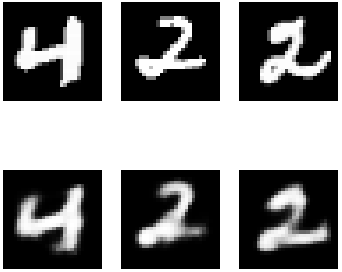

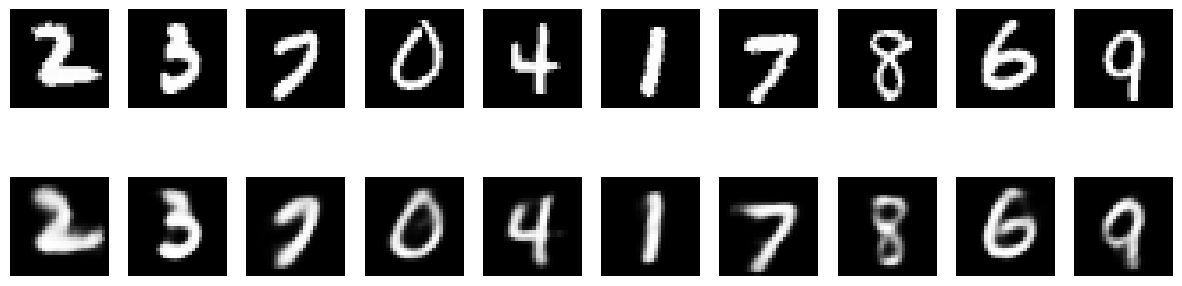

In [26]:
# Reconstruct and visualize some test images
with torch.no_grad():
    for i, (x, _) in enumerate(test_loader):
        x = x.to(device)
        x_recon, _, _ = model_vae(x)
        break  # Only process one batch for visualization
x_recon = x_recon.view(-1, 1, 28, 28)
# Display original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow(x[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(x_recon[i].cpu().squeeze(), cmap='gray')
    axes[1, i].axis('off')

plt.show()

### Visualize VAE sampling results (10 points)
**Note**: You will receive no points if less than or equal to 3 images is clealy recognizable as a digit.

In [27]:
####### TODO: sample 10 images from the model #######
# Sample from Gaussian noise
num_samples = 10
z = torch.randn(num_samples, latent_dim).to(device)

# Generate images from the noise
model_vae.eval()
with torch.no_grad():
    generated_images = model_vae.decoder(z)  # 假设VAE模型有decode方法
    generated_images = generated_images.cpu()

# The output images must be in the generated_images variable.
generated_images = generated_images.view(-1, 28, 28)
##### END TODO sample 10 images from the model #######

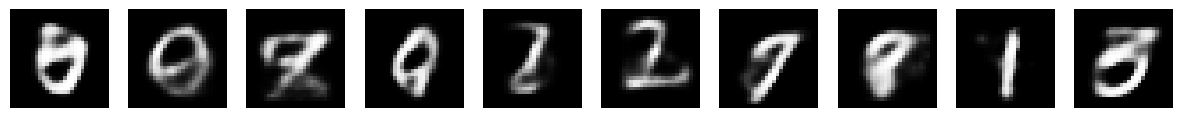

In [28]:
# Visualize the generated images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i].cpu().squeeze().numpy(), cmap='gray')
    ax.axis('off')
plt.show()

# **Conditional Variational AutoEncoder (CVAE)**
(50 points)
CVAE is a type of VAE that also takes an additional condition vector as input such that the generation can be controlled e.g. generating images of digit 3. This vector is generally given as input to both the encoder and decoder model.

In this exercise, we will use a **one-hot encoding** (by calling `F.one_hot()`) to transform the given class label to a vector of size 10, which is then concatenated to both the encoder and decoder input. All other model structures are the same as the VAE above.

In [29]:
class ConditionalEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(ConditionalEncoder, self).__init__()
        ####### TODO: define model layers (5 pts) #######
        # Do not forget to account for the size of the one-hot class vector as well
        self.fc1 = nn.Linear(input_dim + num_classes, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        ####### END TODO define model layers #######

    def forward(self, x, c):
        ####### TODO: forward pass (5 pts) #######
        # Do not forget to concatenate the image and class label
        x = x.view(x.size(0), -1)
        x = torch.cat([x, c], dim=1)
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        ####### END TODO forward pass #######
        return mu, logvar

class ConditionalDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, num_classes):
        super(ConditionalDecoder, self).__init__()
        ####### TODO: define model layers (5 pts) #######
        self.fc1 = nn.Linear(latent_dim + num_classes, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        ####### END TODO define model layers #######

    def forward(self, z, c):
        ####### TODO: implement decoder forward pass (5 pts) #######
        # Compute the output z. The value in z should be in range [0,1] and
        # must be reshape back to (batch_size, 1, 28, 28) or
        # (batch_size, 28, 28) depending on your implementation.
        # Concatenate the latent vector and class label
        z = torch.cat([z, c], dim=1)
        h = F.relu(self.fc1(z))
        z_recon = torch.sigmoid(self.fc2(h))
        z = z_recon.view(-1, 1, 28, 28)
        ####### END TODO implement decoder forward pass #######
        return z

In [30]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim, num_classes):
        super(ConditionalVAE, self).__init__()
        self.encoder = ConditionalEncoder(input_dim, hidden_dim, latent_dim, num_classes)
        self.decoder = ConditionalDecoder(latent_dim, hidden_dim, output_dim, num_classes)

    def reparameterize(self, mu, logvar):
        ####### TODO: implement the reparameterization trick (5 pts) #######
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std
        ##### END TODO: implement the reparameterization trick #####

    def forward(self, x, c):
        mu, logvar = self.encoder(x, c)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z, c)
        return x_recon, mu, logvar

In [31]:
# Define model hyperparameters. ## You can change these to improve the results ##
input_dim = 784  # 28 x 28
hidden_dim = 256
latent_dim = 32

In [32]:
# Define model
num_classes = 10 # MNIST has 10 classes
model_conditional_vae = ConditionalVAE(input_dim, hidden_dim, latent_dim, input_dim, num_classes).to(device)

In [33]:
####### TODO: define an optimizer (5 pts combined with training)#######
# You can use any optimizer you prefer
optimizer = optim.Adam(model_conditional_vae.parameters(), lr=1e-3)
##### END TODO: define an optimizer #####

In [34]:
# Train CVAE model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_conditional_vae = model_conditional_vae.to(device)

####### TODO: implement the training loop of the model #######
# Use the prepared MNIST dataset. You should print the loss every epoch or
# every few hundred steps to see the training progression
# VAE 损失函数
def cvae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

epochs = 10  # You can change this
for epoch in range(epochs):
    model_conditional_vae.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(-1, 784).to(device)  # 展平图像
        target_one_hot = F.one_hot(target, num_classes).float().to(device)

        optimizer.zero_grad()
        x_recon, mu, logvar = model_conditional_vae(data, target_one_hot)
        loss = vae_loss(x_recon, data, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

Epoch 1, Loss: 41.9106
Epoch 2, Loss: 32.1861
Epoch 3, Loss: 30.1669
Epoch 4, Loss: 29.0456
Epoch 5, Loss: 28.3546
Epoch 6, Loss: 27.8946
Epoch 7, Loss: 27.5285
Epoch 8, Loss: 27.2483
Epoch 9, Loss: 27.0351
Epoch 10, Loss: 26.8569


### Test CVAE reconstruction results (5 points) ###
Here, we want to check if the model can do normal reconstruction (no sampling) given input images.
The output images should hopefully be very close to the input images.

Note: **You will receive no points if the reconstructed image is not any similar to the input image.** Acceptable results look similar to this example (top row: test images, bottom row: reconstructed images)

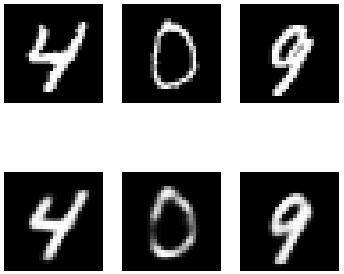

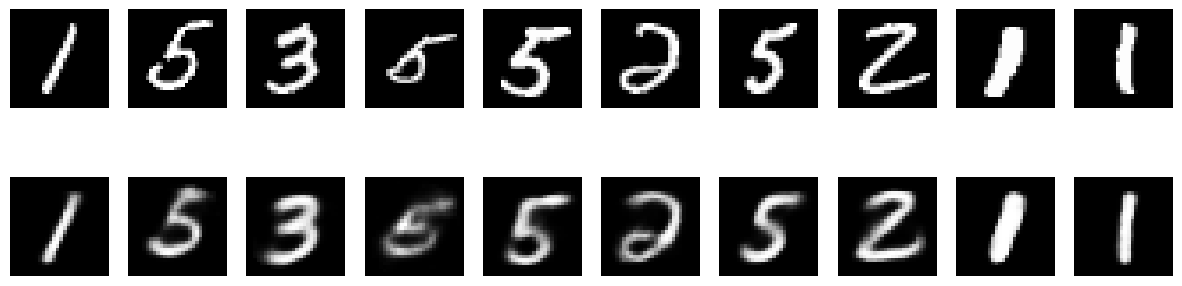

In [35]:
# Test model reconstruction
# Reconstruct and visualize some test images
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device)
        y = y.to(device)
        y_onehot = F.one_hot(y, num_classes=num_classes).float()
        x_recon, _, _ = model_conditional_vae(x, y_onehot)
        break  # Only process one batch for visualization

# Display original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i in range(10):
    axes[0, i].imshow(x[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(x_recon[i].cpu().squeeze(), cmap='gray')
    axes[1, i].axis('off')

plt.show()

### Visualize CVAE sampling results (15 points)

In [36]:
def generate_images_cvae(digit_to_generate):
    '''This function generates 10 sampled images from the given digit class.
    '''
    ####### TODO: sample 10 images from the model #######
    # Sample from Gaussian noise with class label
    model_conditional_vae.eval()  # 设置为评估模式
    num_samples = 10  # 要生成的图像数量
    latent_dim = model_conditional_vae.encoder.fc_mu.out_features  # 获取潜在空间维度
    num_classes = 10
    z = torch.randn(num_samples, latent_dim).to(device)

    # Create one-hot encoded class label
    c = torch.zeros(num_samples, num_classes).to(device)
    c[:, digit_to_generate] = 1.0

    # Generate images from the noise and class label
    #pass

    # The output images must be in the 'generated_images' variable.
    with torch.no_grad():
      generated_images = model_conditional_vae.decoder(z, c)
    ##### END TODO sample 10 images from the model #######

    # Visualize the generated images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].cpu().squeeze().numpy(), cmap='gray')
        ax.axis('off')
    plt.title(f"Generated Images of Digit {digit_to_generate}")
    plt.show()

Minimum expected quality looks similar to this example. You will receive no points if none of the generated images for a given digit is recognisable (the whole digit class fails).

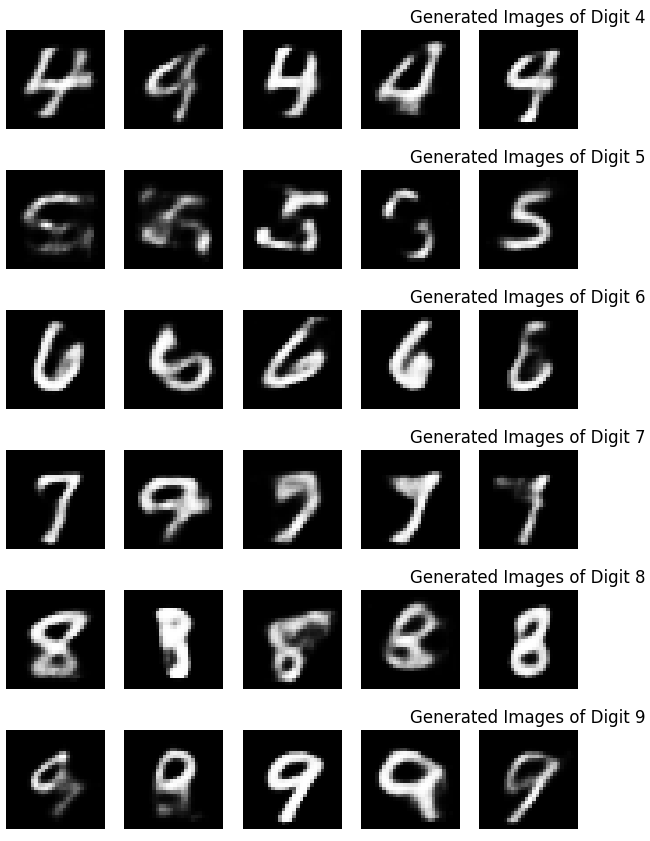

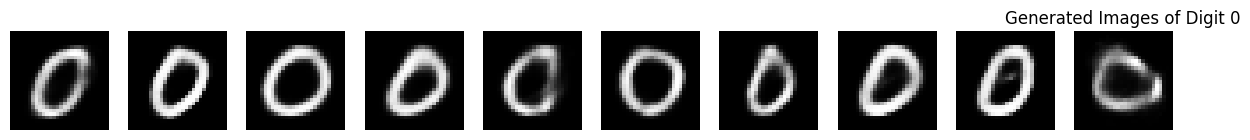

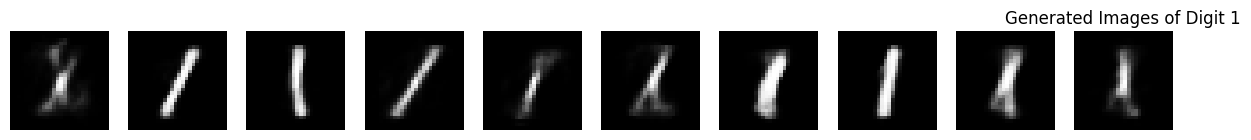

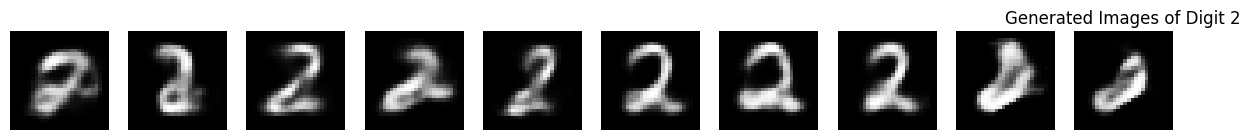

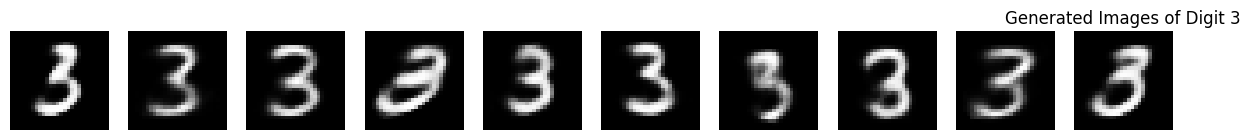

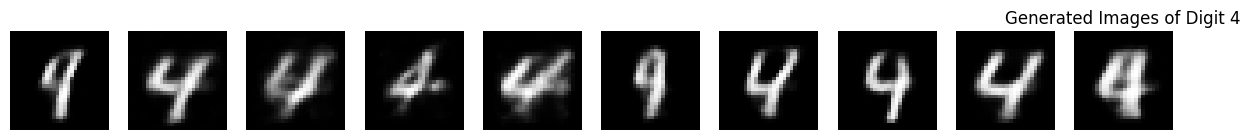

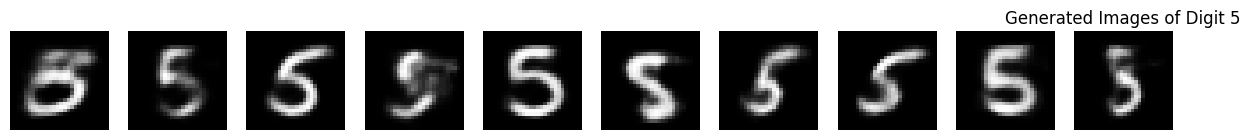

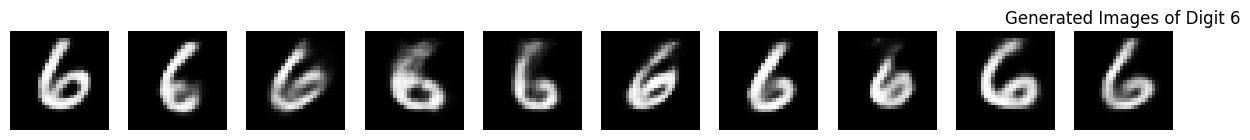

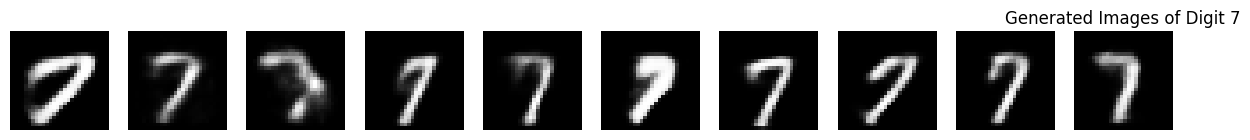

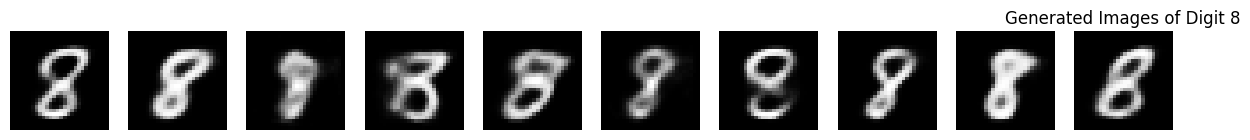

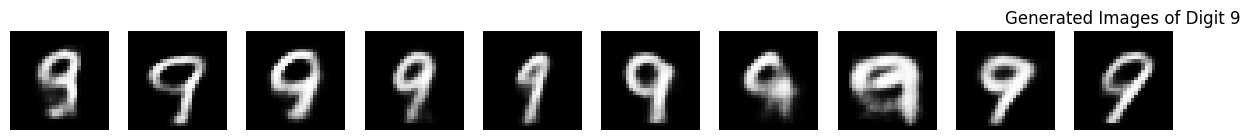

In [37]:
# Visualize 10 sampled images for each digit class.
for i in range(10):
  generate_images_cvae(i)